# Notebook to Investigate LSTM Performance Variance by Huc Type In the Validation Set of the MultiHuc M&M Expirement

# Step 0 - Set up Notebook

In [1]:
# import needed libaries
import os
import boto3
import mlflow
import time
from PIL import Image
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from snowML.datapipe import snow_types as st
from snowML.datapipe import get_geos as gg

In [2]:
# ignore future warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# initialize erathengine credentials
import ee
ee.Authenticate(auth_mode='notebook')

True

# Step1 - Get MLFlow Metrics

In [4]:

# These are the metrics for epoch 28, validation set in the MultiHUc M&M expirement  
f = "valset__metrics_w_snow_types_and_elev.csv"
df_metrics = pd.read_csv(f)
print(df_metrics.shape)
df_metrics.head(2)

(54, 13)


,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
0,170103020101,Little North Fork South Fork Coeur d'Alene Riv...,0.002992,0.710407,Montane Forest,1430.934082,17010302,South Fork Coeur d'Alene,"POLYGON ((-115.629450541972 47.47961590993951,...",orange,Adequate,lightgray,mid
1,170103020102,Canyon Creek-Upper South Fork Coeur d'Alene River,0.004565,0.562041,Montane Forest,1445.485107,17010302,South Fork Coeur d'Alene,POLYGON ((-115.75460827799712 47.5523761135482...,orange,Marginal,darkgray,mid


In [5]:
color_map = {
    "Montane Forest": "orange", 
    "Maritime": "yellow", 
    "Ephemeral": "blue", 
    "Prairie": "red"
}

# Step 2 - Define Plotting Functions 

In [6]:
def plot_scatter(df_merged, color_map, title="Scatter_Plot_of_Test_KGE_vs_Test_MSE_(Colored_by_Predominant_Snow_Type)", save_local=True, show_legend=True):
    """
    Creates a scatter plot of Test KGE vs Test MSE, colored by Predominant Snow Type.
    
    Parameters:
    - df_merged: DataFrame containing "Test MSE", "Test KGE", and "color" columns.
    - color_map: Dictionary mapping labels to their respective colors for the legend.
    - title: Title of the plot (default: "Scatter Plot of Test KGE vs Test MSE (Colored by Predominant Snow Type)" with underscores).
    - save_local: If True, saves the plot as a PNG file.
    - show_legend: If True, shows the legend (default is True).
    """
    plt.figure(figsize=(10, 6))
    
    # Use colors directly from the dataframe, default to white if missing
    colors = df_merged["Snow_Type_Color"].fillna("white")
    
    plt.scatter(df_merged["Test MSE"], df_merged["Test KGE"], c=colors, alpha=0.7, edgecolors="k")
    
    # Add labels and title
    plt.xlabel("Test MSE")
    plt.ylabel("Test KGE")
    plt.title(title.replace("_", " "))
    
    # Show legend if show_legend is True
    if show_legend:
        handles = [plt.Line2D([0], [0], marker='o', color=color, markersize=8, label=label) 
                   for label, color in color_map.items()]
        plt.legend(handles=handles, title="Predominant Snow Type", bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')
    
    plt.show()






In [7]:

def plot_boxplot_by_group(df, parameter, groupby_column="Predominant_Snow", title="Boxplot of Parameter by Group", save_local=True, trunc=False):
    """
    Creates side-by-side box and whisker plots for the given parameter grouped by the specified column.
    
    Parameters:
    - df: DataFrame containing the data to be analyzed.
    - parameter: The column name to be analyzed (e.g., "Test MSE" or "Test KGE").
    - groupby_column: The column name to group by (default: "Predominant_Snow").
    - title: Title of the plot (default: "Boxplot of Parameter by Group").
    - save_local: If True, saves the plot as a PNG file.
    - trunc: If True, truncates x-axis labels to the first 15 characters and rotates them 45 degrees.
    """
    plt.figure(figsize=(10, 6))
    
    # Create boxplot with seaborn
    sns.boxplot(data=df, x=groupby_column, y=parameter, palette="Set2")
    
    # Add labels and title
    plt.xlabel(groupby_column)
    plt.ylabel(parameter)
    plt.title(title.replace("_", " "))
    
    # Truncate x labels and rotate them if trunc is True
    if trunc:
        plt.xticks([i for i in range(len(df[groupby_column].unique()))], 
                   [str(label)[:15] for label in df[groupby_column].unique()], 
                   rotation=90)
    
    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')
    
    plt.show()



In [8]:
def plot_boxplot_by_two_groups(df, parameter, group_by1="Predominant_Snow", group_by2="Elevation Category", 
                               title="Boxplot of Parameter by Group", save_local=False, trunc=False):
    """
    Creates side-by-side box and whisker plots for the given parameter grouped by two specified columns.
    
    Parameters:
    - df: DataFrame containing the data to be analyzed.
    - parameter: The column name to be analyzed (e.g., "Test MSE" or "Test KGE").
    - group_by1: The primary grouping column (e.g., "Predominant Snow Type").
    - group_by2: The secondary grouping column (e.g., "Elevation Category").
    - title: Title of the plot (default: "Boxplot of Parameter by Group").
    - save_local: If True, saves the plot as a PNG file.
    - trunc: If True, truncates x-axis labels to the first 15 characters and rotates them 45 degrees.
    """
    plt.figure(figsize=(12, 6))
    
    # Define a consistent color palette for group_by1 categories
    unique_categories = df[group_by1].unique()
    palette = dict(zip(unique_categories, sns.color_palette("Set2", len(unique_categories))))
    
    # Create boxplot with seaborn
    sns.boxplot(data=df, x=group_by2, y=parameter, hue=group_by1, palette=palette)

    # Add labels and title
    plt.xlabel(group_by2)
    plt.ylabel(parameter)
    plt.title(title.replace("_", " "))

    # Rotate x labels if trunc is True
    if trunc:
        plt.xticks(rotation=45)

    # Show legend outside the plot
    plt.legend(title=group_by1, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show or save plot
    if save_local:
        plt.savefig(f"charts/{title}.png", bbox_inches='tight')

    plt.show()



# Step 3 Create ScatterPlots

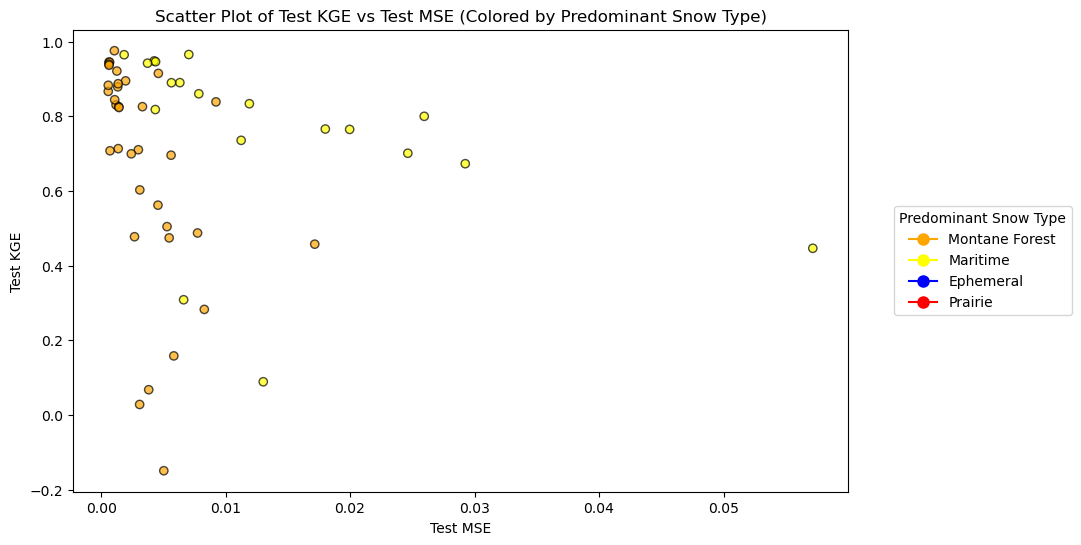

In [9]:
# All results 
plot_scatter(df_metrics, color_map)

In [10]:
# Results with Ephemeral Removed 
df_noE = df_metrics[df_metrics["Predominant_Snow"] != "Ephemeral"]
print(df_noE.shape)

(54, 13)


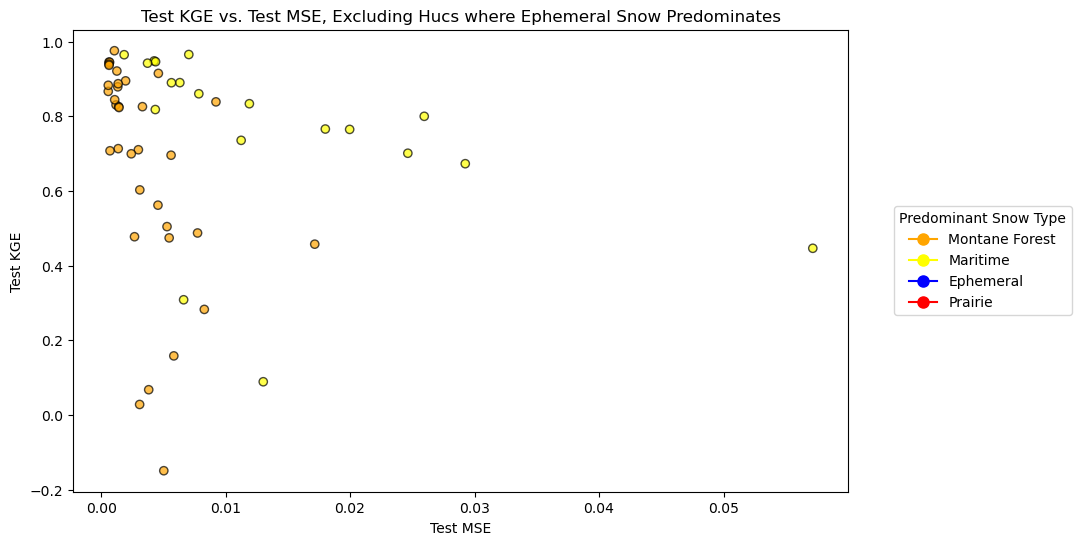

In [11]:
ttl = "Test KGE vs. Test MSE, Excluding Hucs where Ephemeral Snow Predominates"
plot_scatter(df_noE, color_map, title = ttl)

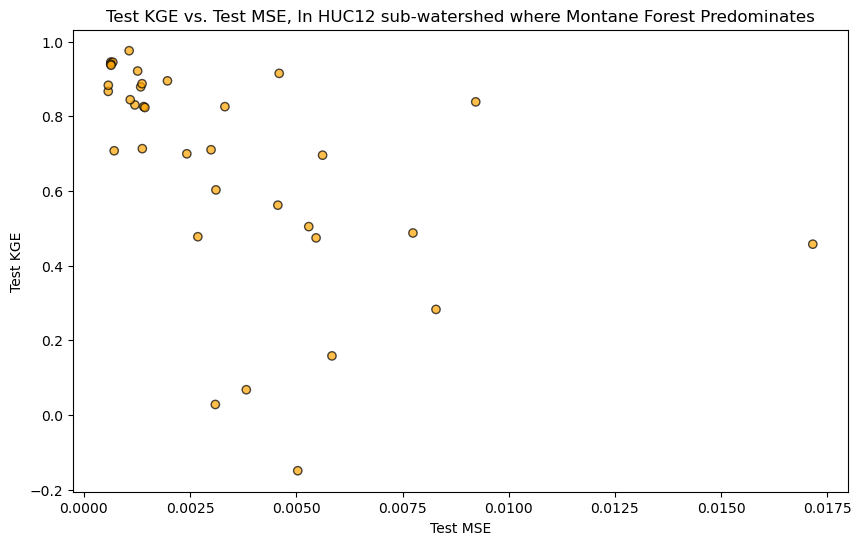

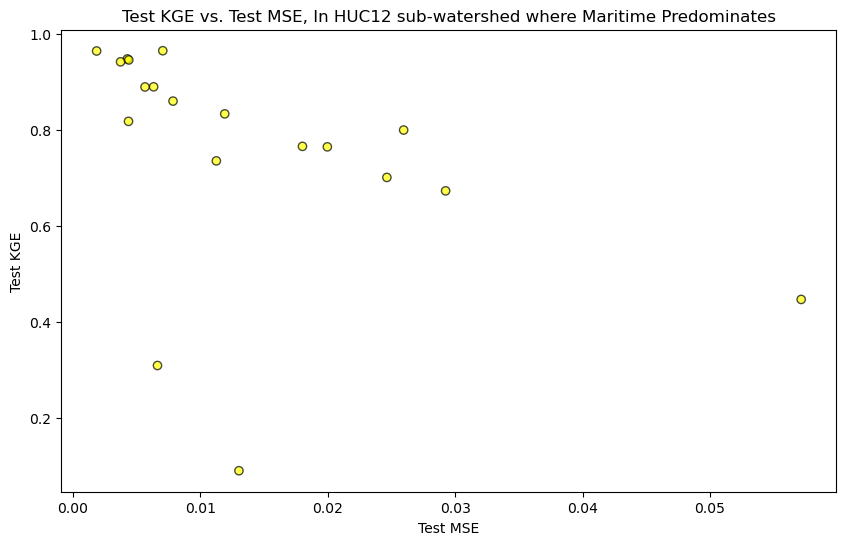

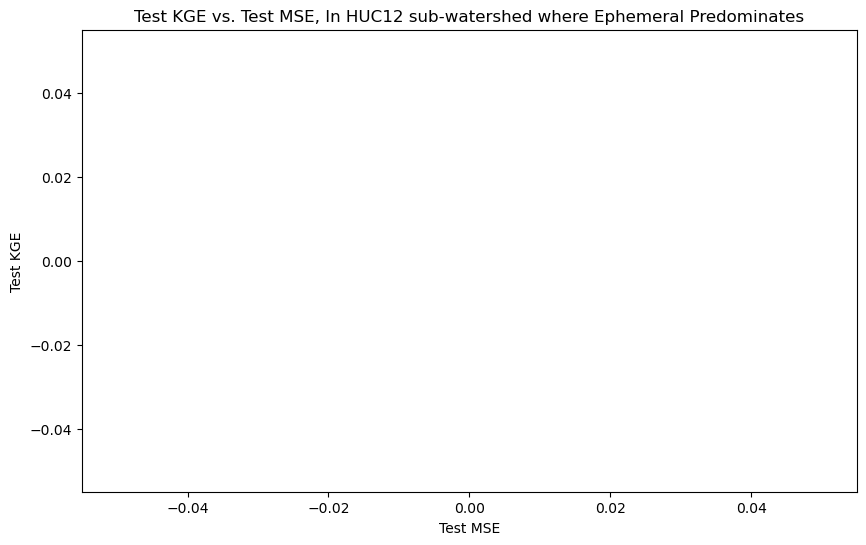

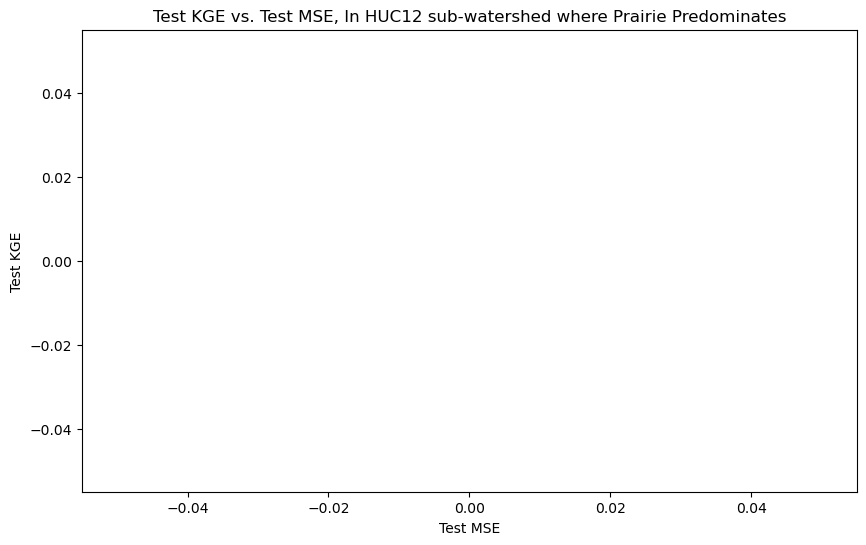

In [12]:
# Scatterlot by snowtype 

for snowtype in color_map.keys():
    df_st = df_metrics[df_metrics["Predominant_Snow"] == snowtype]
    #print(df_st.head(2))
    ttl = f"Test KGE vs. Test MSE, In HUC12 sub-watershed where {snowtype} Predominates"
    plot_scatter(df_st, color_map, title = ttl, show_legend = False)

# NOTE THAT EACH PLOT HAS A DIFFERENT SCALE IN ORDER TO VISUALIZE DIFFERENCES WITHIN SNOWCLASS 
# BUT CAREFUL RE COMPARING ACCROSS SNOWTYPES USING THE BELOW
    

# Step 5 - Create box and whisker plot 

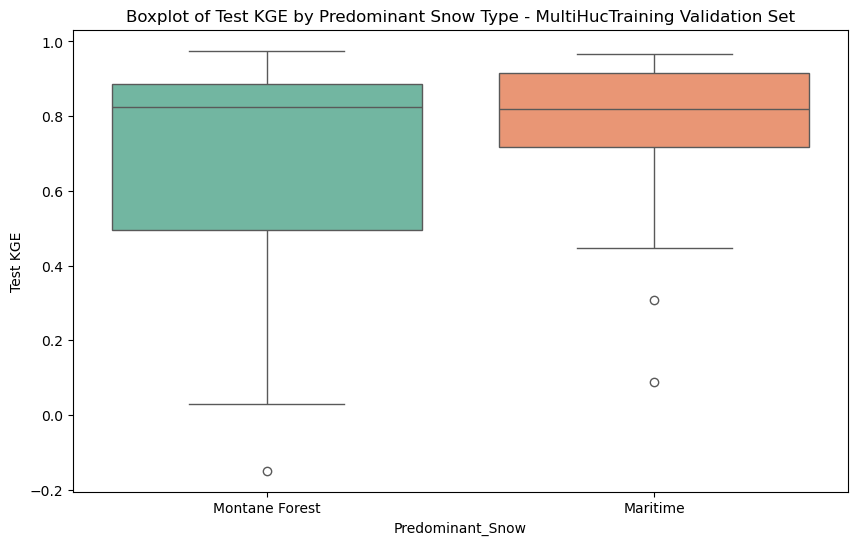

In [13]:
snow_types_to_include = ["Montane Forest", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]
parameter = "Test KGE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - MultiHucTraining Validation Set"
plot_boxplot_by_group(filtered_df, parameter, title= ttl)

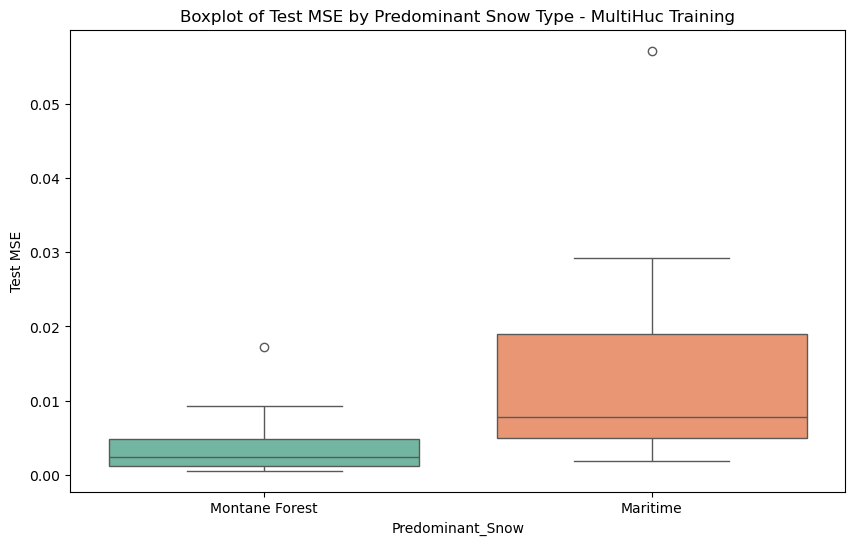

In [14]:
snow_types_to_include = ["Montane Forest", "Ephemeral", "Maritime"]
filtered_df = df_metrics[df_metrics["Predominant_Snow"].isin(snow_types_to_include)]
parameter = "Test MSE"
ttl = f"Boxplot of {parameter} by Predominant Snow Type - MultiHuc Training"
plot_boxplot_by_group(filtered_df, parameter, title= ttl)

# Step 6 Examine by Basin

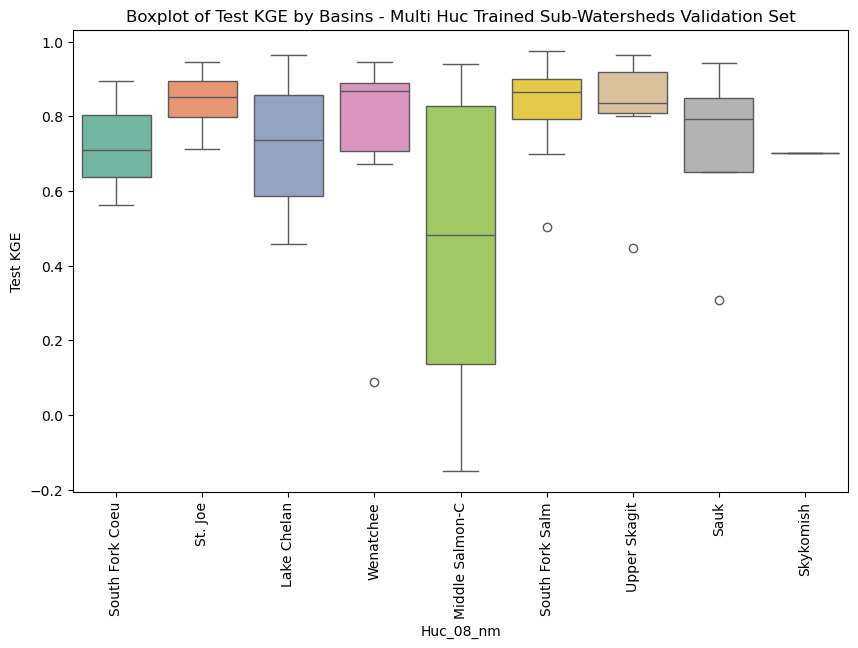

In [15]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - Multi Huc Trained Sub-Watersheds Validation Set"
plot_boxplot_by_group(filtered_df, parameter, title= ttl, groupby_column = groupby, trunc = True)

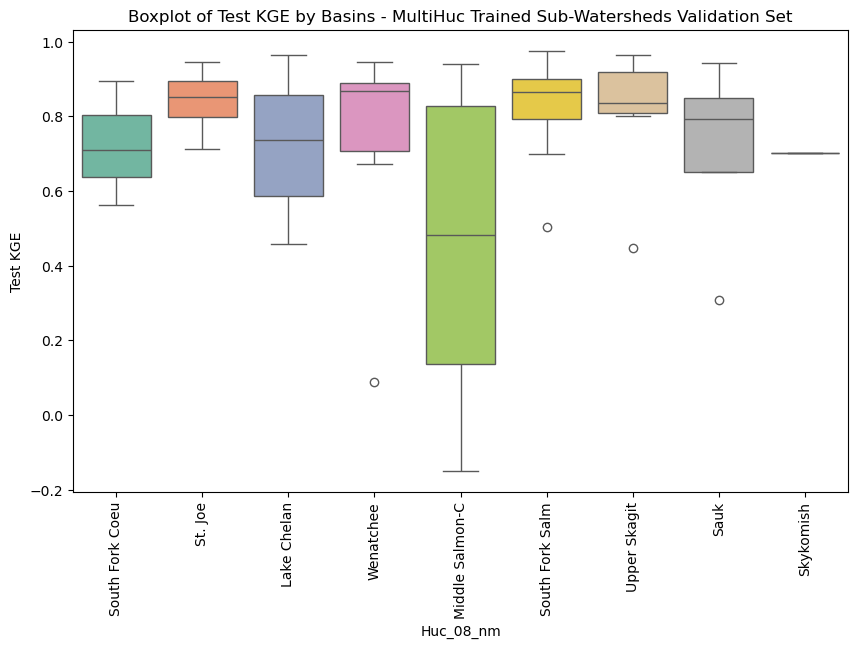

In [16]:
parameter = "Test KGE"
groupby ="Huc_08_nm"
ttl = f"Boxplot of {parameter} by Basins - MultiHuc Trained Sub-Watersheds Validation Set"
plot_boxplot_by_group(df_metrics, parameter, title= ttl, groupby_column = groupby, trunc = True)

# Step 7 Examine by Elevation 

In [17]:
# Define the bins and corresponding labels
bins = [0, 500, 1000, 1500, 2000, float('inf')]
labels = ['low', 'lower mid', 'mid', 'upper mid', 'high']

metrics_w_elev = df_metrics.copy()
# Create the new column 'Elevation Category' based on 'mean_elevation'
metrics_w_elev['Elevation Category'] = pd.cut(metrics_w_elev['mean_elevation'], bins=bins, labels=labels, right=False)

# Display the updated GeoDataFrame
print(metrics_w_elev[['mean_elevation', 'Elevation Category']].head(2))


   mean_elevation Elevation Category
0     1430.934082                mid
1     1445.485107                mid


In [18]:
# data frame with elevation that excludes ephemeral snow 
metrics_w_elev_noE = filtered_df.copy()
metrics_w_elev_noE['Elevation Category'] = pd.cut(metrics_w_elev_noE['mean_elevation'], bins=bins, labels=labels, right=False)
print(metrics_w_elev_noE[['mean_elevation', 'Elevation Category']].head(2))


   mean_elevation Elevation Category
0     1430.934082                mid
1     1445.485107                mid


In [19]:
# data frame with elevation that includes only Maritime and Montane Forest 
metrics_MandM = df_metrics.loc[df_metrics["Predominant_Snow"].isin(["Maritime", "Montane Forest"])]

metrics_w_elev_MandM = metrics_MandM.copy()
metrics_w_elev_MandM['Elevation Category'] = pd.cut(metrics_w_elev_MandM['mean_elevation'], bins=bins, labels=labels, right=False)
print(metrics_w_elev_MandM[['mean_elevation', 'Elevation Category']].head(2))


   mean_elevation Elevation Category
0     1430.934082                mid
1     1445.485107                mid


In [20]:
# Count occurrences of each elevation category
elevation_counts = metrics_w_elev['Elevation Category'].value_counts()

# Print the counts
print(elevation_counts)

Elevation Category
upper mid    24
mid          19
high          8
lower mid     3
low           0
Name: count, dtype: int64


In [21]:
# Create a cross-tabulation of Elevation Category by Predominant Snow Type
elevation_snow_counts = pd.crosstab(metrics_w_elev['Elevation Category'], metrics_w_elev['Predominant_Snow'])

# Print the table
print(elevation_snow_counts)

Predominant_Snow    Maritime  Montane Forest
Elevation Category                          
lower mid                  2               1
mid                        8              11
upper mid                  9              15
high                       0               8


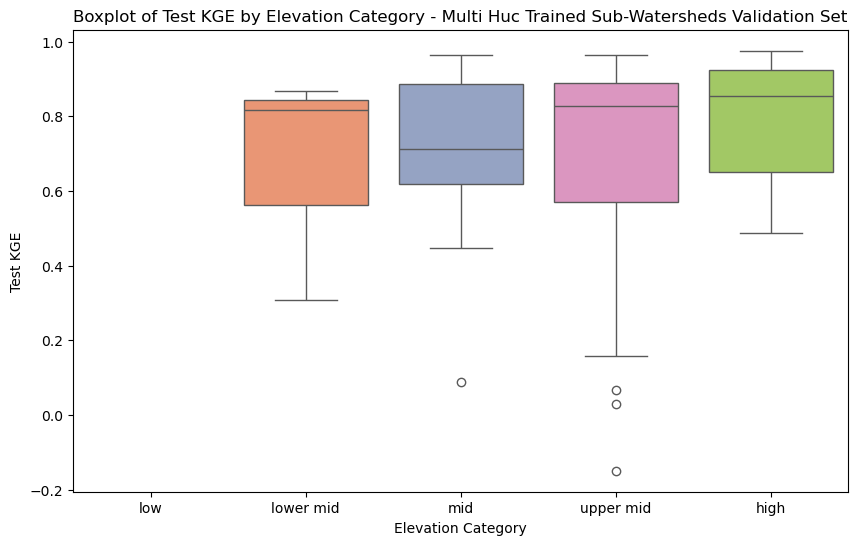

In [22]:
parameter = "Test KGE"
groupby ="Elevation Category"
ttl = f"Boxplot of {parameter} by {groupby} - Multi Huc Trained Sub-Watersheds Validation Set"
plot_boxplot_by_group(metrics_w_elev, parameter, title= ttl, groupby_column = groupby)

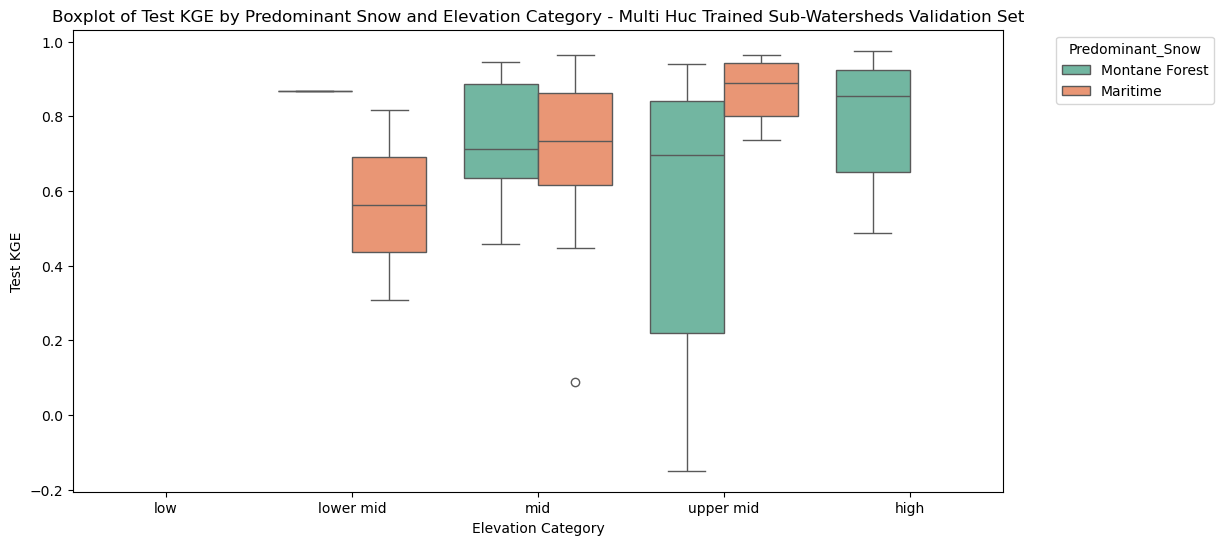

In [23]:
parameter = "Test KGE"
group_by1 = "Predominant_Snow"
group_by2 ="Elevation Category"
ttl = f"Boxplot of {parameter} by {group_by1} and {group_by2} - Multi Huc Trained Sub-Watersheds Validation Set"
plot_boxplot_by_two_groups(metrics_w_elev_MandM, parameter, group_by1=group_by1, group_by2=group_by2, title=ttl)

# Step Last Examine Outliers

In [24]:
# extract the five rows with highest MSE - what do they have in common? 
largest_mse = (df_metrics.nlargest(5, "Test MSE"))
print(largest_mse)

          HUC_ID                      Name  Test MSE  Test KGE  \
48  171100051004               Swift Creek  0.057169  0.446566   
14  170200110101              Indian Creek  0.029250  0.673058   
47  171100050801  North Fork Cascade River  0.025955  0.799920   
53  171100090103                Foss River  0.024637  0.701069   
7   170200090105                Flat Creek  0.019963  0.764870   

   Predominant_Snow  mean_elevation    Huc_08     Huc_08_nm  \
48         Maritime     1163.793823  17110005  Upper Skagit   
14         Maritime     1474.834717  17020011     Wenatchee   
47         Maritime     1507.020630  17110005  Upper Skagit   
53         Maritime     1262.375488  17110009     Skykomish   
7          Maritime     1541.539062  17020009   Lake Chelan   

                                             geometry Snow_Type_Color  \
48  POLYGON ((-121.60267339840995 48.8315759849717...          yellow   
14  POLYGON ((-120.98966444455417 47.9629136308360...          yellow   
47  P

In [25]:
for huc_id in largest_mse["HUC_ID"]:
    geos = gg.get_geos_with_name(huc_id, '12')
    #print(geos)
    largest_mse.loc[largest_mse["HUC_ID"] == huc_id, "Name"] = geos.iloc[0]["name"]
    largest_mse.loc[largest_mse["HUC_ID"] == huc_id, "geometry"] = geos.iloc[0]["geometry"]
largest_mse_gdf = gpd.GeoDataFrame(largest_mse, geometry="geometry")
largest_mse_gdf.set_crs("EPSG:4326", inplace=True) 

largest_mse_gdf

,HUC_ID,Name,Test MSE,Test KGE,Predominant_Snow,mean_elevation,Huc_08,Huc_08_nm,geometry,Snow_Type_Color,Test KGE Class,Test KGE color,Elevation Category
48,171100051004,Swift Creek,0.057169,0.446566,Maritime,1163.793823,17110005,Upper Skagit,"POLYGON ((-121.60267 48.83158, -121.60272 48.8...",yellow,Poor,Black,mid
14,170200110101,Indian Creek,0.029250,0.673058,Maritime,1474.834717,17020011,Wenatchee,"POLYGON ((-120.98966 47.96291, -120.98936 47.9...",yellow,Marginal,darkgray,mid
47,171100050801,North Fork Cascade River,0.025955,0.799920,Maritime,1507.020630,17110005,Upper Skagit,"POLYGON ((-121.03602 48.49512, -121.03617 48.4...",yellow,Adequate,lightgray,upper mid
53,171100090103,Foss River,0.024637,0.701069,Maritime,1262.375488,17110009,Skykomish,"POLYGON ((-121.22447 47.66702, -121.22533 47.6...",yellow,Adequate,lightgray,mid
7,170200090105,Flat Creek,0.019963,0.764870,Maritime,1541.539062,17020009,Lake Chelan,"POLYGON ((-120.91729 48.42521, -120.91751 48.4...",yellow,Adequate,lightgray,upper mid


In [26]:
largest_mse_gdf.explore()